[![Open In Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/timsainb/tensorflow2-generative-models/blob/master/6.0-VAE-GAN-fashion-mnist.ipynb)

## VAE-GAN ([article](https://arxiv.org/abs/1512.09300)) 
VAE-GAN combines the VAE and GAN to autoencode over a latent representation of data in the generator to improve over the pixelwise error function used in autoencoders. 

![vae gan](https://github.com/timsainb/tensorflow2-generative-models/blob/f3360a819b5773692e943dfe181972a76b9d91bb/imgs/vaegan.png?raw=1)

### Install packages if in colab

In [0]:
### install necessary packages if in colab
def run_subprocess_command(cmd):
    process = subprocess.Popen(cmd.split(), stdout=subprocess.PIPE)
    for line in process.stdout:
        print(line.decode().strip())


import sys, subprocess

IN_COLAB = "google.colab" in sys.modules
colab_requirements = [
    "pip install tf-nightly-gpu-2.0-preview==2.0.0.dev20190513",
    "pip install tfp-nightly==0.7.0.dev20190508",
]
if IN_COLAB:
    for i in colab_requirements:
        run_subprocess_command(i)

#### Note: to get this working on fashion MNIST without using any sort of batch normalization I added two parameters: `latent_loss_div` and `recon_loss_div`. Their purpose is just to scale the loss of the KL Divergence and the reconstruction error in order to balance the three losses in the generator (reconstruction, KL divergence, GAN). Similar to $\beta$-VAE. In addition I balance the generator and discriminator loss by squashing the discriminator loss with a sigmoid based on how much it is beating the generator by.

#### In addition - the quality of samples continues to improve well past 50 epochs - so I reccomend training for longer than I did here! I'm sure you could also find better hyperparameters to improve training speeds. 

### load packages

In [4]:
!pip install tensorflow==2.1.0
!pip install tensorflow-probability==0.9.0

Processing /Users/bo/Library/Caches/pip/wheels/21/7f/02/420f32a803f7d0967b48dd823da3f558c5166991bfd204eef3/gast-0.2.2-py3-none-any.whl
ERROR: tensorflow-probability 0.10.0rc0 has requirement gast>=0.3.2, but you'll have gast 0.2.2 which is incompatible.
ERROR: rlcard 0.1.9 has requirement tensorflow<2.0,>=1.14, but you'll have tensorflow 2.1.0 which is incompatible.
ERROR: rlcard 0.1.9 has requirement tensorflow_probability==0.7.0, but you'll have tensorflow-probability 0.10.0rc0 which is incompatible.
  Attempting uninstall: gast
    Found existing installation: gast 0.3.3
    Uninstalling gast-0.3.3:
      Successfully uninstalled gast-0.3.3
     |████████████████████████████████| 3.2 MB 726 kB/s 
ERROR: rlcard 0.1.9 has requirement tensorflow<2.0,>=1.14, but you'll have tensorflow 2.1.0 which is incompatible.
ERROR: rlcard 0.1.9 has requirement tensorflow_probability==0.7.0, but you'll have tensorflow-probability 0.9.0 which is incompatible.
  Attempting uninstall: tensorflow-probab

In [1]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
from tqdm.autonotebook import tqdm
%matplotlib inline
from IPython import display
import pandas as pd
import tensorflow_probability as tfp
ds = tfp.distributions
import random
import time

In [2]:
print(tf.__version__, tfp.__version__)

2.1.0 0.9.0


### Create a fashion-MNIST dataset

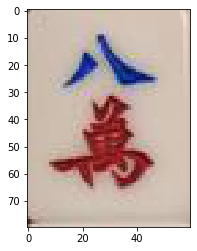

In [3]:
# load dataset
labels = pd.read_csv('data.csv')
subset = labels['label']
labels_mixed = labels[subset.between(1, 27)]["image-name"].tolist()
def get_tiles(paths):
    imgs = [plt.imread('tiles_small/' + path) for path in paths]
    return np.stack(imgs)

X = (get_tiles(labels_mixed).reshape(-1, 80, 60, 3)).astype(np.float32)/255.0
plt.imshow(X[0])
N = X.shape[0]

In [4]:
TRAIN_BUF=int(N*0.8)
BATCH_SIZE=int(N*0.2)
TEST_BUF= N - TRAIN_BUF
DIMS = (80,60,3)
N_TRAIN_BATCHES =int(TRAIN_BUF/BATCH_SIZE)
N_TEST_BATCHES = int(TEST_BUF/BATCH_SIZE)

In [5]:
sample = random.sample(range(N), TRAIN_BUF)
# split dataset
train_images = X[sample]
test_images = X[[i for i in range(N) if i not in sample]]

# batch datasets
train_dataset = (
    tf.data.Dataset.from_tensor_slices(train_images)
    .shuffle(TRAIN_BUF)
    .batch(BATCH_SIZE)
)
test_dataset = (
    tf.data.Dataset.from_tensor_slices(test_images)
    .shuffle(TEST_BUF)
    .batch(BATCH_SIZE)
)

### Define the network as tf.keras.model object

In [6]:
class VAEGAN(tf.keras.Model):
    """a VAEGAN class for tensorflow
    
    Extends:
        tf.keras.Model
    """

    def __init__(self, **kwargs):
        super(VAEGAN, self).__init__()
        self.__dict__.update(kwargs)

        self.enc = tf.keras.Sequential(self.enc)
        self.dec = tf.keras.Sequential(self.dec)
        inputs, disc_l, outputs = self.vae_disc_function()
        self.disc = tf.keras.Model(inputs=[inputs], outputs=[outputs, disc_l])

        self.enc_optimizer = tf.keras.optimizers.Adam(self.lr_base_gen, beta_1=0.5)
        self.dec_optimizer = tf.keras.optimizers.Adam(self.lr_base_gen, beta_1=0.5)
        self.disc_optimizer = tf.keras.optimizers.Adam(self.get_lr_d, beta_1=0.5)

    def encode(self, x):
        mu, sigma = tf.split(self.enc(x), num_or_size_splits=2, axis=1)
        return mu, sigma

    def dist_encode(self, x):
        mu, sigma = self.encode(x)
        return ds.MultivariateNormalDiag(loc=mu, scale_diag=sigma)

    def get_lr_d(self):
        return self.lr_base_disc * self.D_prop

    def decode(self, z):
        return self.dec(z)

    def discriminate(self, x):
        return self.disc(x)

    def reconstruct(self, x):
        mean, _ = self.encode(x)
        return self.decode(mean)

    def reparameterize(self, mean, logvar):
        eps = tf.random.normal(shape=mean.shape)
        return eps * tf.exp(logvar * 0.5) + mean

    # @tf.function
    def compute_loss(self, x):
        # pass through network
        q_z = self.dist_encode(x)
        z = q_z.sample()
        p_z = ds.MultivariateNormalDiag(
            loc=[0.0] * z.shape[-1], scale_diag=[1.0] * z.shape[-1]
        )
        xg = self.decode(z)
        z_samp = tf.random.normal([x.shape[0], 1, 1, z.shape[-1]])
        xg_samp = self.decode(z_samp)
        d_xg, ld_xg = self.discriminate(xg)
        d_x, ld_x = self.discriminate(x)
        d_xg_samp, ld_xg_samp = self.discriminate(xg_samp)

        # GAN losses
        disc_real_loss = gan_loss(logits=d_x, is_real=True)
        disc_fake_loss = gan_loss(logits=d_xg_samp, is_real=False)
        gen_fake_loss = gan_loss(logits=d_xg_samp, is_real=True)

        discrim_layer_recon_loss = (
            tf.reduce_mean(tf.reduce_mean(tf.math.square(ld_x - ld_xg), axis=0))
            / self.recon_loss_div
        )

        self.D_prop = sigmoid(
            disc_fake_loss - gen_fake_loss, shift=0.0, mult=self.sig_mult
        )

        kl_div = ds.kl_divergence(q_z, p_z)
        latent_loss = tf.reduce_mean(tf.maximum(kl_div, 0)) / self.latent_loss_div

        return (
            self.D_prop,
            latent_loss,
            discrim_layer_recon_loss,
            gen_fake_loss,
            disc_fake_loss,
            disc_real_loss,
        )

    # @tf.function
    def compute_gradients(self, x):
        with tf.GradientTape() as enc_tape, tf.GradientTape() as dec_tape, tf.GradientTape() as disc_tape:
            (
                _,
                latent_loss,
                discrim_layer_recon_loss,
                gen_fake_loss,
                disc_fake_loss,
                disc_real_loss,
            ) = self.compute_loss(x)

            enc_loss = latent_loss + discrim_layer_recon_loss
            dec_loss = gen_fake_loss + discrim_layer_recon_loss
            disc_loss = disc_fake_loss + disc_real_loss

        enc_gradients = enc_tape.gradient(enc_loss, self.enc.trainable_variables)
        dec_gradients = dec_tape.gradient(dec_loss, self.dec.trainable_variables)
        disc_gradients = disc_tape.gradient(disc_loss, self.disc.trainable_variables)

        return enc_gradients, dec_gradients, disc_gradients

    @tf.function
    def apply_gradients(self, enc_gradients, dec_gradients, disc_gradients):
        self.enc_optimizer.apply_gradients(
            zip(enc_gradients, self.enc.trainable_variables)
        )
        self.dec_optimizer.apply_gradients(
            zip(dec_gradients, self.dec.trainable_variables)
        )
        self.disc_optimizer.apply_gradients(
            zip(disc_gradients, self.disc.trainable_variables)
        )

    def train(self, x):
        enc_gradients, dec_gradients, disc_gradients = self.compute_gradients(x)
        self.apply_gradients(enc_gradients, dec_gradients, disc_gradients)


def gan_loss(logits, is_real=True):
    """Computes standard gan loss between logits and labels
                
        Arguments:
            logits {[type]} -- output of discriminator
        
        Keyword Arguments:
            isreal {bool} -- whether labels should be 0 (fake) or 1 (real) (default: {True})
        """
    if is_real:
        labels = tf.ones_like(logits)
    else:
        labels = tf.zeros_like(logits)

    return tf.compat.v1.losses.sigmoid_cross_entropy(
        multi_class_labels=labels, logits=logits
    )


def sigmoid(x, shift=0.0, mult=20):
    """ squashes a value with a sigmoid
    """
    return tf.constant(1.0) / (
        tf.constant(1.0) + tf.exp(-tf.constant(1.0) * (x * mult))
    )


### Define the network architecture
- GAIA has an autoencoder as its generator, and a UNET as its descriminator

In [7]:
N_Z = 128

In [24]:
encoder = [
    tf.keras.layers.InputLayer(input_shape=DIMS),
    tf.keras.layers.Conv2D(
        filters=32, kernel_size=3, strides=(2, 2), activation="relu"
    ),
    tf.keras.layers.Conv2D(
        filters=64, kernel_size=3, strides=(2, 2), activation="relu"
    ),
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(units=N_Z*2),
]

decoder = [
    tf.keras.layers.Dense(units=20 * 15 * 64, activation="relu"),
    tf.keras.layers.Reshape(target_shape=(20, 15, 64)),
    tf.keras.layers.Conv2DTranspose(
        filters=64, kernel_size=3, strides=(2, 2), padding="SAME", activation="relu"
    ),
    tf.keras.layers.Conv2DTranspose(
        filters=32, kernel_size=3, strides=(2, 2), padding="SAME", activation="relu"
    ),
    tf.keras.layers.Conv2DTranspose(
        filters=3, kernel_size=3, strides=(1, 1), padding="SAME", activation="sigmoid"
    ),
]

def vaegan_discrim():
    inputs = tf.keras.layers.Input(shape=(80, 60, 3))
    conv1 = tf.keras.layers.Conv2D(
                filters=32, kernel_size=3, strides=(2, 2), activation="relu"
            )(inputs)
    conv2 = tf.keras.layers.Conv2D(
                filters=64, kernel_size=3, strides=(2, 2), activation="relu"
            )(conv1)
    flatten = tf.keras.layers.Flatten()(conv2)
    lastlayer = tf.keras.layers.Dense(units=512, activation="relu")(flatten)
    outputs = tf.keras.layers.Dense(units=1, activation = None)(lastlayer)
    return inputs, lastlayer, outputs

### Create Model

In [9]:
# the unet function 
gen_optimizer = tf.keras.optimizers.Adam(1e-3, beta_1=0.5)
disc_optimizer = tf.keras.optimizers.RMSprop(1e-3)
    
# model
model = VAEGAN(
    enc = encoder,
    dec = decoder,
    vae_disc_function = vaegan_discrim,
    lr_base_gen = 1e-3, # 
    lr_base_disc = 1e-4, # the discriminator's job is easier than the generators so make the learning rate lower
    latent_loss_div=1, # this variable will depend on your dataset - choose a number that will bring your latent loss to ~1-10
    sig_mult = 10, # how binary the discriminator's learning rate is shifted (we squash it with a sigmoid)
    recon_loss_div = .001, # this variable will depend on your dataset - choose a number that will bring your latent loss to ~1-10
)

### Train the model

In [10]:
# exampled data for plotting results
example_data = next(iter(train_dataset))

In [11]:
model.train(example_data)

In [12]:
def plot_reconstruction(model, epoch, example_data, nex=8, zm=2):

    example_data_reconstructed = model.reconstruct(example_data)
    samples = model.decode(tf.random.normal(shape=(BATCH_SIZE, N_Z)))
    fig, axs = plt.subplots(ncols=nex, nrows=3, figsize=(zm * nex, zm * 3))
    for axi, (dat, lab) in enumerate(
        zip(
            [example_data, example_data_reconstructed, samples],
            ["data", "data recon", "samples"],
        )
    ):
        for ex in range(nex):
            axs[axi, ex].imshow(dat.numpy()[ex].squeeze())
            axs[axi, ex].axes.get_xaxis().set_ticks([])
            axs[axi, ex].axes.get_yaxis().set_ticks([])
        axs[axi, 0].set_ylabel(lab)
    if (epoch % 10 == 0): 
        plt.savefig(f'mahjong_gan/mixed/VAEGAN_epoch_{epoch}_{time.strftime("%H-%M-%s")}.png', bbox_inches='tight')
    plt.show()
    
def plot_losses(losses):
    fig, axs =plt.subplots(ncols = 4, nrows = 1, figsize= (16,4))
    axs[0].plot(losses.latent_loss.values, label = 'latent_loss')
    axs[1].plot(losses.discrim_layer_recon_loss.values, label = 'discrim_layer_recon_loss')
    axs[2].plot(losses.disc_real_loss.values, label = 'disc_real_loss')
    axs[2].plot(losses.disc_fake_loss.values, label = 'disc_fake_loss')
    axs[2].plot(losses.gen_fake_loss.values, label = 'gen_fake_loss')
    axs[3].plot(losses.d_prop.values, label = 'd_prop')

    for ax in axs.flatten():
        ax.legend()
    if (epoch % 10 == 0): 
        plt.savefig(f'mahjong_gan/character/VAEGAN_loss2.png', bbox_inches='tight')
    plt.show()

In [13]:
# a pandas dataframe to save the loss information to
losses = pd.DataFrame(columns=[
    'd_prop',
    'latent_loss',
    'discrim_layer_recon_loss',
    'gen_fake_loss',
    'disc_fake_loss',
    'disc_real_loss',
])

Epoch: 0


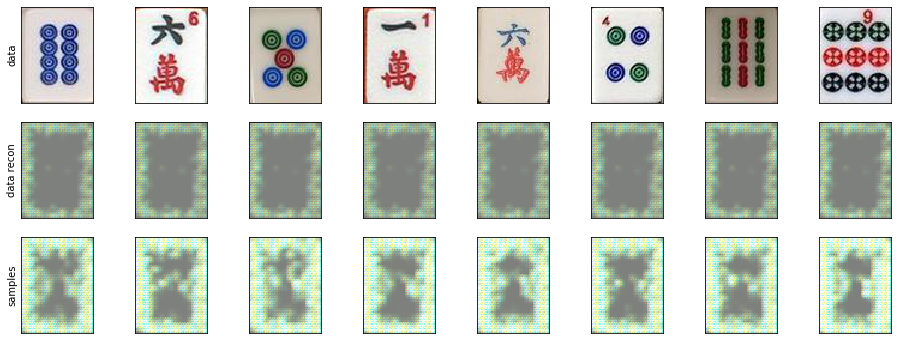

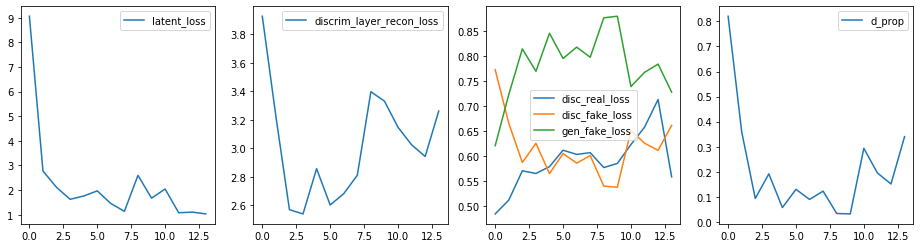

In [25]:
initial_epoch = 0
end_epoch = 1
for epoch in range(initial_epoch, end_epoch):
    # train
    for batch, train_x in tqdm(
        zip(range(N_TRAIN_BATCHES), train_dataset), total=N_TRAIN_BATCHES
    ):
        model.train(train_x)
    # test on holdout
    loss = []
    for batch, test_x in tqdm(
        zip(range(N_TEST_BATCHES), train_dataset), total=N_TEST_BATCHES
    ):
        loss.append(model.compute_loss(train_x))
    losses.loc[len(losses)] = np.mean(loss, axis=0)
    # plot results
    display.clear_output()
    print(
        "Epoch: {}".format(epoch)
    )
    plot_reconstruction(model, epoch, example_data)
    plot_losses(losses)

In [17]:
tf.keras.models.save_weights(model.enc, "enc")

AttributeError: module 'tensorflow_core.keras.models' has no attribute 'save_weights'

In [19]:
model.save_weights("save_model")

In [26]:
model2 = VAEGAN(
    enc = encoder,
    dec = decoder,
    vae_disc_function = vaegan_discrim,
    lr_base_gen = 1e-3, # 
    lr_base_disc = 1e-4, # the discriminator's job is easier than the generators so make the learning rate lower
    latent_loss_div=1, # this variable will depend on your dataset - choose a number that will bring your latent loss to ~1-10
    sig_mult = 10, # how binary the discriminator's learning rate is shifted (we squash it with a sigmoid)
    recon_loss_div = .001, # this variable will depend on your dataset - choose a number that will bring your latent loss to ~1-10
)

In [28]:
model2.load_weights("save_model")

Epoch: 0


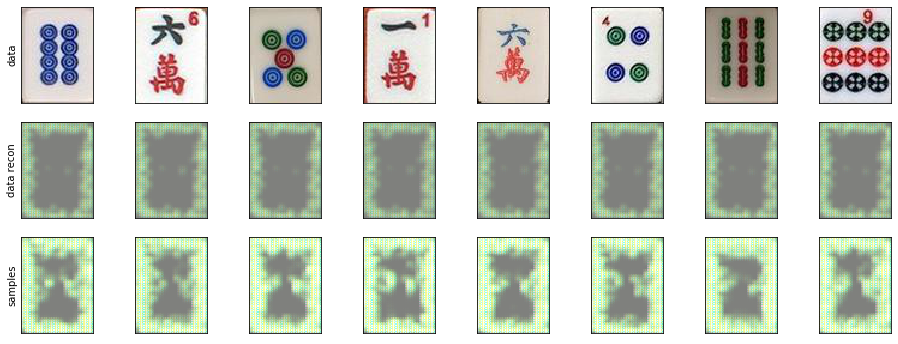

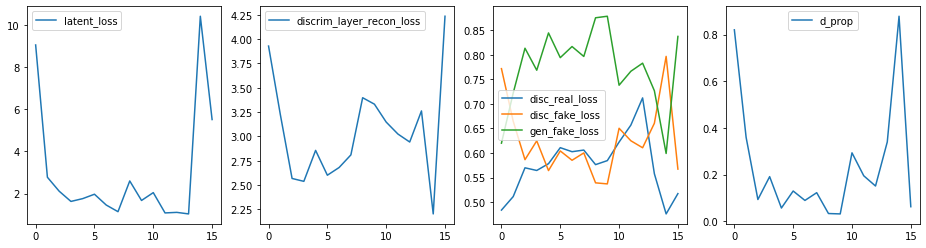

In [29]:
initial_epoch = 0
end_epoch = 1
for epoch in range(initial_epoch, end_epoch):
    # train
    for batch, train_x in tqdm(
        zip(range(N_TRAIN_BATCHES), train_dataset), total=N_TRAIN_BATCHES
    ):
        model2.train(train_x)
    # test on holdout
    loss = []
    for batch, test_x in tqdm(
        zip(range(N_TEST_BATCHES), train_dataset), total=N_TEST_BATCHES
    ):
        loss.append(model2.compute_loss(train_x))
    losses.loc[len(losses)] = np.mean(loss, axis=0)
    # plot results
    display.clear_output()
    print(
        "Epoch: {}".format(epoch)
    )
    plot_reconstruction(model2, epoch, example_data)
    plot_losses(losses)